# Physics-Informed Autoencoders for Virtual Pathology of Prostate

In [1]:
from PIA import PIA, get_batch, hybrid_fit, density_scatter, detect_PIDS_slice, ADC_slice
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import time
from torch import optim
import torch
from IPython import display
import mat73
import os
import scipy.io as sio
from skimage import morphology
from skimage import segmentation
from numpy.matlib import repmat
#import itertools
#from tqdm import tqdm



## Hybrid 1.0 fit MC test

100%|██████████| 25/25 [00:01<00:00, 18.56it/s]


Hybrid 1.0 takes 1.3833179473876953 seconds


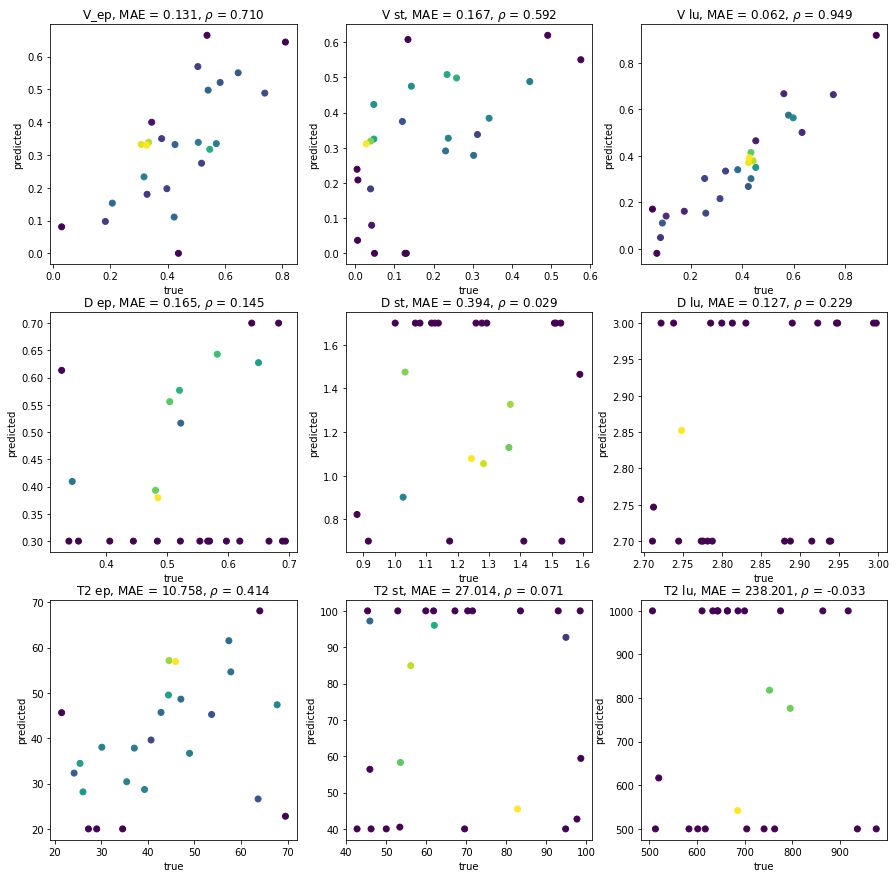

In [11]:
test, D_test2, T2_test2, v_test2, _ = get_batch(25)
test = test.detach().cpu().numpy()
start = time.time()
D, T2, v = hybrid_fit(test)
end = time.time()
print(f'Hybrid 1.0 takes {end - start} seconds')

fig, ax = plt.subplots(3,3, figsize=(15,15))
for r in range(3):
    for c in range(3):
        if r==0:
            x_image, y_image = v_test2, v
            title = ['V_ep', 'V st', 'V lu']
            ylims = [(0,1), (0,1), (0,1)]
        elif r==1:
            x_image, y_image = D_test2, D
            title = ['D ep', 'D st', 'D lu']
            ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]

        else:
            x_image, y_image = T2_test2, T2
            title = ['T2 ep', 'T2 st', 'T2 lu']
            ylims = [(20, 70), (40, 100), (500, 1000)]

        density_scatter(x_image.detach().cpu().numpy()[:,c] , 
                        y_image[:, c], ax = ax[r,c], sort = True, bins = 15)
        err = np.mean(np.abs(x_image.detach().cpu().numpy()[:,c]-y_image[:, c]))
        corr = np.corrcoef(x_image.detach().cpu().numpy()[:,c],y_image[:, c])[0,1]

        ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
        ax[r,c].set_xlabel('true')
        ax[r,c].set_ylabel('predicted')
        #ax[r,c].set_ylim(ylims[c])

## PIA MC Test

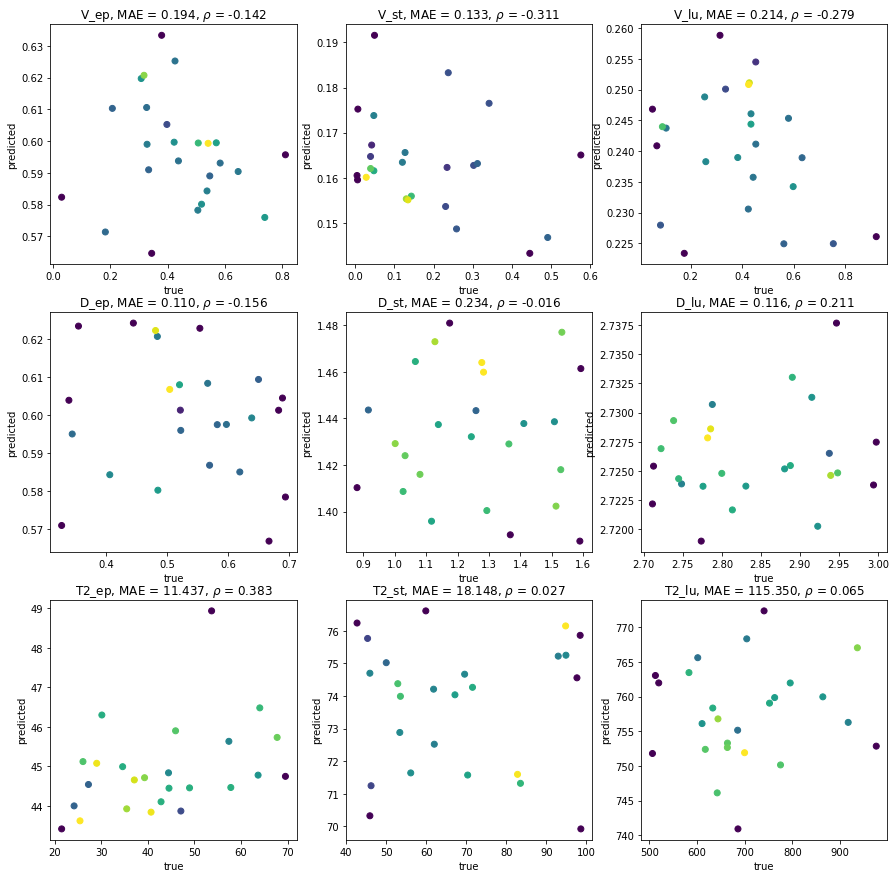

KeyboardInterrupt: 

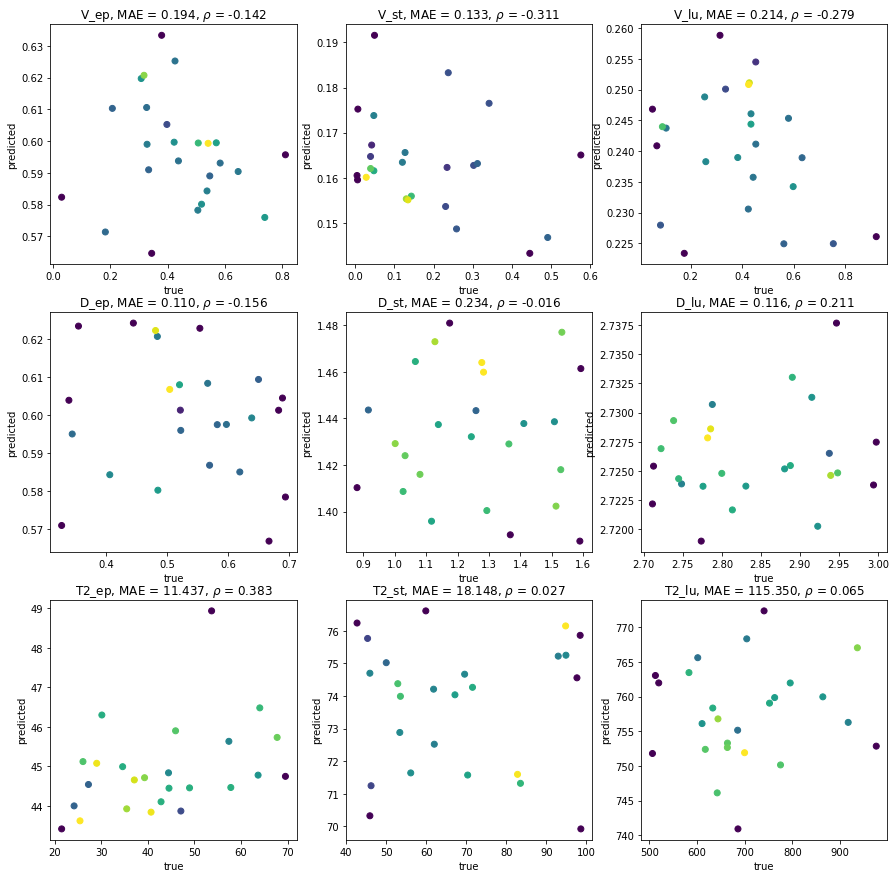

In [14]:
model =  PIA(predictor_depth=2)
params = list(model.encoder.parameters()) + list(model.v_predictor.parameters()) + list(model.D_predictor.parameters()) + list(model.T2_predictor.parameters())
optimizer = optim.Adam(params, lr=0.0001)


ctr = 1
total_loss = 0 
# We are testing on the same random test set
test_tensor = torch.from_numpy(test).cuda()
for ep in range(50000):
 
    x, D_true, T2_true, v_true, y = get_batch(128)
    x , y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    D, T2, v = model.encode(x)        
    recon = model.decode(D, T2, v).cuda()
    PIDS = torch.from_numpy(np.ones((128, 16))).cuda()
    loss = model.loss_function(recon, y, PIDS, tissue_available=False)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    if not ep % 10000:

        D, T2, v = model.encode(test_tensor)
        bins = (50, 50)
        fig, ax = plt.subplots(3,3, figsize=(15,15), facecolor='white')
        for r in range(3):
            for c in range(3):
                if r==0:
                    x_image, y_image = v_test2, v
                    title = ['V_ep', 'V_st', 'V_lu']

                elif r==1:
                    x_image, y_image = D_test2, D
                    title = ['D_ep', 'D_st', 'D_lu']
                    ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]

                else:
                    x_image, y_image = T2_test2, T2
                    title = ['T2_ep', 'T2_st', 'T2_lu']
                    ylims = [(20, 70), (40, 100), (500, 1000)]
                
                density_scatter(x_image.detach().cpu().numpy()[:,c] , 
                                y_image.detach().cpu().numpy()[:, c], ax = ax[r,c], sort = True, bins = 15)
                err = np.mean(np.abs(x_image.detach().cpu().numpy()[:,c]-y_image.detach().cpu().numpy()[:, c]))
                corr = np.corrcoef(x_image.detach().cpu().numpy()[:,c],y_image.detach().cpu().numpy()[:, c])[0,1]
                ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
                ax[r,c].set_xlabel('true')
                ax[r,c].set_ylabel('predicted')
                #ax[r,c].set_ylim(ylims[c])
        display.display(plt.gcf())
    print(f'{total_loss/ctr}',end ="\r")
    ctr += 1
PATH = 'pia_model.pt'
torch.save(model, PATH)

### Select Patient Data

In [10]:

BASE_ADDRESS = '/home/gundogdu/Downloads'
data_address = os.path.join(BASE_ADDRESS, 'pat083_hybridSortedInput.mat')
print('Loading data')

try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address) 
print('Data loaded')

b_values = data['b']
TE_values = data['TE']
TE_norm = data['TE_norm']
hybrid_data = data['hybrid_data']

hybrid_normalized = np.zeros_like(hybrid_data)

for b in range(4):
    for te in range(4):
        hybrid_normalized[:, :, :, b, te] = 1000*hybrid_data[:, :, :, b, te]/(hybrid_data[:, :, :, 0, 0] + 1e-7)

Loading data
Data loaded


In [11]:
_slice = 15
_from = 35
_to = 95

hybrid_data2 = np.reshape(hybrid_normalized, (128, 128, hybrid_data.shape[2], 16))
model_input = np.squeeze(hybrid_data2[_from: _to, _from: _to, _slice, :])
bins = (model_input.shape[0], model_input.shape[1])
model_input = np.reshape(model_input, (model_input.shape[0]*model_input.shape[1], 16))

### In-vivo test on Hybrid1.0

In [5]:
start = time.time()
D, T2, v = hybrid_fit(model_input)
end = time.time()

print(f'Hybrid 1.0 took {end - start} seconds')

fig, ax = plt.subplots(3,3, figsize=(15,15))
for r in range(3):
    for c in range(3):
        if r==0:
            x_image = v
            title = ['epithelium volume', 'stroma volume', 'lumen volume']
            ylims = [(0,1), (0,1), (0,1)]
        elif r==1:
            x_image = D
            title = ['epithelium ADC', 'stroma ADC', 'lumen ADC']
            ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]

        else:
            x_image =  T2
            title = ['epithelium T2', 'stroma T2', 'lumen T2']
            ylims = [(20, 70), (40, 100), (500, 1000)]

        im = ax[r,c].imshow(np.reshape(x_image[:,c], bins), vmin=ylims[c][0], vmax=ylims[c][1],cmap='jet')
        ax[r,c].set_title(fr'{title[c]}')
        divider = make_axes_locatable(ax[r,c])
        cax = divider.append_axes("right", size="5%", pad=0.05)

        plt.colorbar(im, cax=cax)
        #ax[r,c].set_ylim(ylims[c])

PIDS_1, PIDS_2, PIDS_3, PIDS_4 = detect_PIDS_slice(b_values, hybrid_data[_from:_to, _from:_to, _slice, :, :])
PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
for i in range(0,3):
    for j in range(0,2):
        PIDS += PIDS_3[:,:,i, j].astype(float)

PIDS = 1 - (PIDS>0).astype(float)
PIDS = morphology.remove_small_objects(PIDS.astype(bool), min_size=50, connectivity=50)
PIDS = morphology.remove_small_holes(PIDS, area_threshold=50, connectivity=1)
v_ep = np.reshape(v[:,0], bins) 
v_lu = np.reshape(v[:,2], bins)
cancer = (v_ep > 0.4)#*(v_lu <= 0.2)

adc_map = ADC_slice(b_values, np.squeeze(hybrid_data[_from: _to, _from : _to, _slice, :, 0]))
fig, ax = plt.subplots(1, figsize=(6,6))
fig.suptitle('predicted cancer map')
ax.imshow(adc_map, cmap='gray')
cancer_map = np.multiply(cancer.astype(float), PIDS.astype(float))
cancer_map = morphology.remove_small_objects(cancer_map.astype(bool), min_size=12, connectivity=1)
cancer_map = cancer_map.astype(float)
cancer_map[cancer_map==0] = np.nan
ax.imshow(cancer_map, cmap='autumn',alpha = 0.4)
ax.axis('off')

  4%|▍         | 159/3600 [00:05<02:08, 26.73it/s]


KeyboardInterrupt: 

### In-vivo tests with PIA 

100%|██████████| 60/60 [00:01<00:00, 35.87it/s]


PIA took 0.0025703907012939453 seconds


(-0.5, 59.5, 59.5, -0.5)

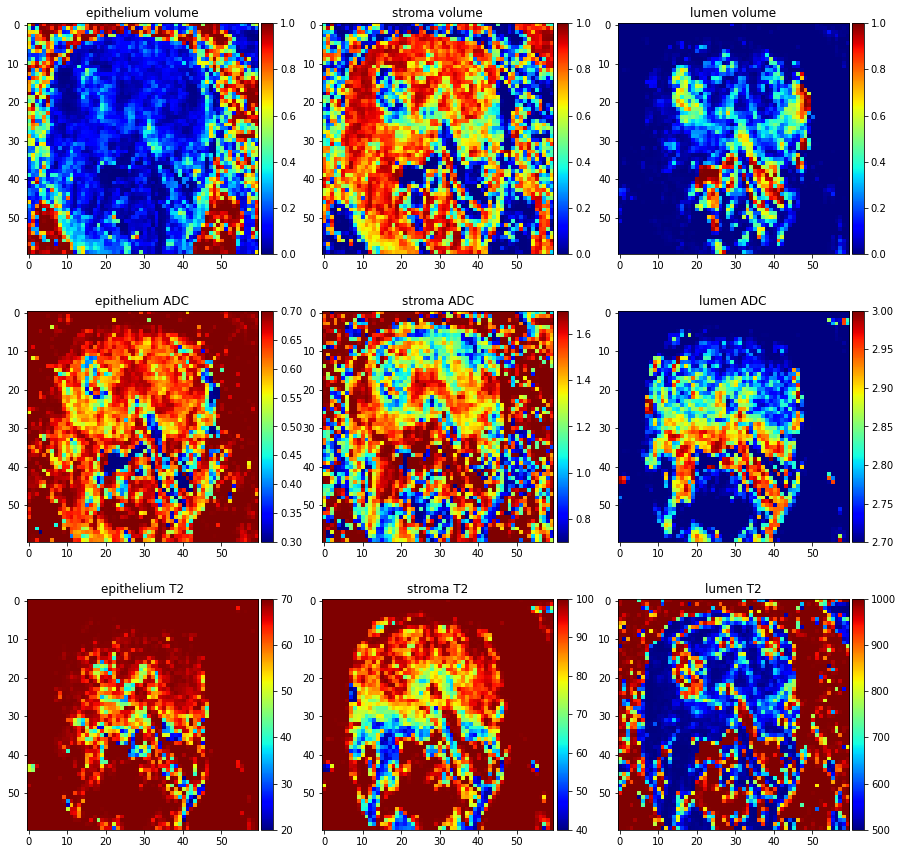

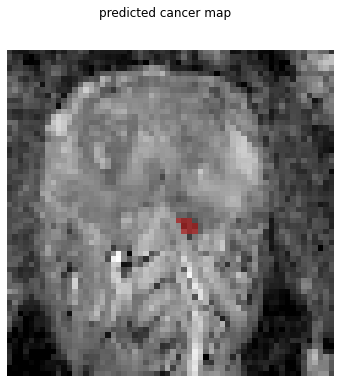

In [18]:
fine_tune = False
PATH = 'pia_model.pt'
model = torch.load(PATH)
PIDS_1, PIDS_2, PIDS_3, PIDS_4 = detect_PIDS_slice(b_values, hybrid_data[_from:_to, _from:_to, _slice, :, :])
PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
for i in range(0,3):
    for j in range(0,2):
        PIDS += PIDS_3[:,:,i, j].astype(float)

PIDS = 1 - (PIDS>0).astype(float)
PIDS = morphology.remove_small_objects(PIDS.astype(bool), min_size=50, connectivity=50)
PIDS = morphology.remove_small_holes(PIDS, area_threshold=50, connectivity=1)

model_input_tensor = torch.from_numpy(model_input)
model_input_tensor = model_input_tensor.float().cuda()
start = time.time()
D, T2, v = model.encode(model_input_tensor)
end = time.time()
print(f'PIA took {end - start} seconds')

fig, ax = plt.subplots(3,3, figsize=(15,15))
if fine_tune:
    params = list(model.encoder.parameters()) + list(model.v_predictor.parameters()) + list(model.D_predictor.parameters()) + list(model.T2_predictor.parameters())
    optimizer = optim.Adam(params, lr=0.0005)
    ctr = 1
    total_loss = 0 
    for ep in range(1000):

        optimizer.zero_grad()
        D, T2, v = model.encode(model_input_tensor)        
        recon = model.decode(D, T2, v).cuda()
        PIDS_tensor = torch.from_numpy(repmat(np.reshape(PIDS, (PIDS.shape[0]*PIDS.shape[1], 1)),1,16)).float().cuda()
        loss = model.loss_function(recon, model_input_tensor, PIDS_tensor, tissue_available=False)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f'{total_loss/ctr}',end ="\r")
        ctr += 1
for r in range(3):
    for c in range(3):
        if r==0:
            x_image = v
            title = ['epithelium volume', 'stroma volume', 'lumen volume']
            ylims = [(0,1), (0,1), (0,1)]
        elif r==1:
            x_image = D
            title = ['epithelium ADC', 'stroma ADC', 'lumen ADC']
            ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]

        else:
            x_image =  T2
            title = ['epithelium T2', 'stroma T2', 'lumen T2']
            ylims = [(20, 70), (40, 100), (500, 1000)]
        im = ax[r,c].imshow(np.reshape(x_image[:,c].detach().cpu().numpy(), bins), vmin=ylims[c][0], vmax=ylims[c][1],cmap='jet')
        divider = make_axes_locatable(ax[r,c])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax[r,c].set_title(fr'{title[c]}')
v_ep = np.reshape(v[:,0].detach().cpu().numpy(), bins) 
v_lu = np.reshape(v[:,2].detach().cpu().numpy(), bins)
cancer = (v_ep > 0.35)#*(v_lu <= 0.2)

adc_map = ADC_slice(b_values, np.squeeze(hybrid_data[_from: _to, _from : _to, _slice, :, 0]))
fig, ax = plt.subplots(1, figsize=(6,6))
fig.suptitle('predicted cancer map')
ax.imshow(adc_map, cmap='gray')
cancer_map = np.multiply(cancer.astype(float), PIDS.astype(float))
cancer_map = morphology.remove_small_objects(cancer_map.astype(bool), min_size=9, connectivity=1)
cancer_map = cancer_map.astype(float)
cancer_map[cancer_map==0] = np.nan
ax.imshow(cancer_map, cmap='autumn',alpha = 0.4)
ax.axis('off')
